# Adam Optimizer low level로 구현하기

# High level Adam API와 완전히 같은 Optimizer 직접 구현하기

Ans : 수식의 차이<br>
 - 텐서플로우 문서에서 Adam 논문 Section 2.1바로전의 수식을 사용했다고 명시함 <br>

 ![Tensorflow adam 문서](https://github.com/Deepstroy/Inventory/blob/master/about%20optimizer/Adam_TF_%EB%AC%B8%EC%84%9C.PNG?raw=true)
 <br> <br>

 - 처음 구현한 Low level 수식은 아래와 같음 <br>

 ![대체 텍스트](https://github.com/Deepstroy/Inventory/blob/master/about%20optimizer/Adam_algorithm1.PNG?raw=true)
 <br> <br>

 - 그러나 Section 2.1에서 아래와 같이 구현하기로 함. <br>

   해당 수식은 m_hat과 v_hat을 weight update수식에 대입하여 풀이한것 <br>

   ![대체 텍스트](https://github.com/Deepstroy/Inventory/blob/master/about%20optimizer/revised%20formula.PNG?raw=true)
    <br>

#####Kingma, D. P., & Ba, J. (2014). *Adam: A method for stochastic optimization.* arXiv preprint arXiv:1412.6980.

### Adam또한 아래와 같은 Rosenbrock(르젠브록 함수)를 사용해 최적해를 찾아가는 Optimizer를 시험해 보려한다.


​
${\displaystyle f(x,y)=(1-x)^{2}+100(y-x^{2})^{2}}$
​

![Imgur](https://i.imgur.com/qMRFEAZ.png) 

In [0]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

### 먼저 rosenbrock에서 grid search를 사용하여 최소값을 찾는다.

In [2]:
def rosenbrock (x, y):
    return (1-x) ** 2 + 100*(y - x**2) ** 2


# start point : x:-3, y:-2 에서 시작합니다.  
start_x, start_y = -3., -2.
start_z = rosenbrock(start_x, start_y)
start_xy = tf.constant([start_x, start_y])

# xy coordinate with z : 좌표 grid 을 생성합니다.
x, y = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = rosenbrock(x, y)


# find minimum z : rosenbrock 에서 최소값을 찾습니다.
index = np.argmin(np.ravel(z))
min_x, min_y, min_z = list(map(lambda k: np.ravel(k)[index], [x, y, z]))

print(min_x, min_y, min_z)

0.9900000000000018 0.9800000000000018 0.00010099999999999995


W0626 11:56:44.997806 139654712321920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


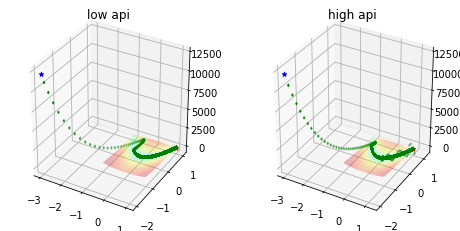

In [3]:
lr = 0.1
esp = 1e-8
beta_v = 0.9 # beta 1
beta_g = 0.999 # beta 2

xy = tf.Variable(initial_value=start_xy, dtype=tf.float32, name='xy')

#####beta1/2, lr Variable####################
beta_v_tf = tf.Variable(tf.constant(beta_v))# beta 1
beta_g_tf = tf.Variable(tf.constant(beta_g))# beta 2 
lr_tf = tf.constant(lr)                     #
#############################################

# 이동값, [Adam은 RMSP와 Momentum의 조합 Optimizer]
g = tf.Variable(tf.constant(value = [0.,0.]))
v = tf.Variable(tf.constant(value = [0.,0.]))

# gradient
grad_xy = tf.gradients(rosenbrock(xy[0],xy[1]), xy)[0]

################################################################################
#Adam Optimizer tensorflow style code based on Adam Optimizer paper(ICLR 2015) #
#Use the formula just before section 2.1.                                      #
##Adam Optimizer########################################################       #
V_assign = tf.assign(v, ((beta_v_tf*v) + ((1-beta_v_tf)*(grad_xy))))   #       #
G_assign = tf.assign(g, ((beta_g_tf*g) + ((1-beta_g_tf)*(grad_xy**2))))#       #
beta_g_asig = tf.pow(beta_g_tf,2)                                      #       #
beta_v_asig = tf.pow(beta_v_tf,2)                                      #       #
lr_t = lr_tf * tf.sqrt(1-beta_g_asig) / (1-beta_v_asig)                #       #
step = tf.assign_sub(xy, (lr_t * V_assign / tf.sqrt(G_assign+(esp))))  #       #
########################################################################       #
################################################################################

# TF's High level API
step_api = tf.train.AdamOptimizer(lr,beta_v,beta_g,esp)\
                        .minimize(rosenbrock(xy[0],xy[1]))

# 시각화
steps = [step, step_api] 
titles = ['low api', 'high api'] 
fig = plt.figure(figsize=plt.figaspect(0.5))
for ind in range(2):
    ax = fig.add_subplot(1,2,ind+1,projection='3d')
    # plot start point 
    ax.plot_surface(x, y, z, cmap=plt.cm.jet, alpha=0.3, norm=LogNorm())
    ax.scatter(xs=min_x, ys=min_y, marker='*', color='r')
    ax.scatter(xs=start_x, ys=start_y, zs=rosenbrock(-3, -2), marker='*', color='b')

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    xy_history = []
    g_history = []
    for i in range(15000):
        _, xy_, g_ = sess.run([steps[ind], xy, g])
        xy_history.append(xy_)
        g_history.append(g_)
    xy_history = np.stack(xy_history, axis=0)
    ax.scatter(xs=xy_history[:, 0],
               ys=xy_history[:, 1],
               zs=rosenbrock(xy_history[:, 0], xy_history[:, 1]),
               marker='d', color='g', s=3)
    ax.set_title(titles[ind])
plt.show()